# "You Snooze, You Win" Challenge

Every year, the [PhysioNet/CinC (Computing in Cardiology) Challenge](https://www.physionet.org/challenge/) invites "participants to tackle clinically interesting problems that are either unsolved or not well-solved." For this year's week 2 machine learning challenge, BWSI has revived a past PhysioNet challenge based on sleep classification.

This year's challenge focuses on the classification of nonarousal and arousal timeframes. If you would like to understand the biological implications of the challenge, we recommend reading PhysioNet's [introduction](https://physionet.org/challenge/2018/) of the challenge.

For this challenge, you will classify samples into 5 classes (Arousal, NREM1, NREM2, NREM3, REM). Each sample consists of seven physiological signals (O2-M1, E1-M2, Chin1-Chin2, ABD, CHEST, AIRFLOW, ECG) measured at 200 Hz over a 60 second period (12000 timepoints). In this notebook, we provide code to import the data, visualize sample signals, implement an example classifier, and 'score' your model.

In [2]:
### Import libraries ###

from google.colab import files
import matplotlib.pyplot as plt
import matplotlib

#set default plotting fonts
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

import numpy as np
import os
import pandas as pd
import random
from sklearn import metrics
from sklearn.utils import shuffle
import tensorflow as tf

#data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#garbage collection (for saving RAM during training)
import gc


## Loading the Dataset

This dataset is a modified version of the PhysioNet/CinC Challenge data, which were contributed by the Massachusetts General Hospital’s Computational Clinical Neurophysiology Laboratory, and the Clinical Data Animation Laboratory.
***
**Class labels:**
- 0 = Arousal
- 1 = NREM1
- 2 = NREM2
- 3 = NREM3
- 4 = REM
***
**Class descriptions:**

<img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/blob/master/Images/Week2/sleepStagesTable.svg?raw=true">

***
**Physiological signal description:**

O2-M1 - posterior brain activity (electroencephalography)

E1-M2 - left eye activity (electrooculography)

Chin1-Chin2 - chin movement (electromyography)

ABD - abdominal movement (electromyography)

CHEST - chest movement (electromyography)

AIRFLOW - respiratory airflow

ECG - cardiac activity (electrocardiography)
***
Run both cell blocks to get the challenge data.

In [3]:
# Clone repo and move into data directory (only run this once)
!git clone https://github.com/BeaverWorksMedlytics2020/Data_Public
os.chdir('./Data_Public/ChallengeProjects/Week2/')

fatal: destination path 'Data_Public' already exists and is not an empty directory.


## Loading Data in Memory
Run the cell below to extract the raw training and test data. It may take a minute or two to run through. Here are the variables containing the data you will get:

* **data_train**: np array shape (4000, 12000, 7). Contains 4000 samples (60s each) of 12000 data points (200Hz x 60s), for 7 different signals. 
* **labels_train**: np array shape (4000,). Contains ground truth labels for data_train. The order of the labels corresponds to the order of the training data.
* **ID_train**: list of 4000 unique IDs. The order of the IDs corresponds to the order of the training data. 
* **data_test**: np array shape (1000, 12000, 7). Contains 1000 samples (60s each) of 12000 data points (200Hz x 60s), for 7 different signals.
* **ID_test**: list of 1000 unique IDs. The order of the IDs corresponds to the order of the training data.

We encourage you to print each of these variables to see what they look like.

In [4]:
### Run once to import data ###

def get_file_locs():
    '''
    find all files in 'training' and 'test' directories and put their names 
    under 'training' and 'test' keys in the file_dict dictionary
    '''

    file_dict = {'training':[], 'test':[]}
    for data_type in file_dict:
        for file in os.listdir('./' + data_type):
            file_dict[data_type].append(data_type + '/' + file)
    
    return file_dict

def get_sample_data(data_type, id_number):
    '''
    get signal data, label, and filename associated with given data type and index num

    parameters:

     data_type -- Dictates whether sample comes from training set or test set.
                 This input must be either 'training' or 'test' (defaults to 'training')

     id_number -- Which sample ID should be returned? Must be 0-3999 if data_type is 'training'
                 or 0-999 if data_type is 'test' (defaults to random integer from 0-999)
  
    returns:

     sample_data -- dataframe with 1 row and 2 columns-- column "Signal" contains a series object 
                    and column "Label" contains numeric label for that sample
    '''
    file = './' + data_type + '/' + str(id_number) + '.xz'

    #sample_data is a dataframe with 1 row and 2 columns--
    #"Signal" (contains a series object) and "Label" (contains numeric label)
    sample_data = pd.read_pickle('./' + file)

    return sample_data, file.split('/')[2]

file_dict = get_file_locs()
print(f"{len(file_dict['training'])} training samples found, {len(file_dict['test'])} test samples found")

data_train = np.zeros((4000, 12000, 7))
labels_train = np.zeros(4000)
ID_train = []
for i in range(4000):
  sample_data, ID = get_sample_data('training', i)
  data_train[i] = np.array(list(sample_data['Signal']), dtype=np.float).reshape(12000, 7)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=np.float)
  ID_train.append(ID)
  if(i%500==0):
    print('Loading training sample ' + str(i))
  
data_test = np.zeros((1000, 12000, 7))
ID_test = []
for i in range(1000):
  sample_data, ID = get_sample_data('test', i)
  data_test[i] = np.array(list(sample_data['Signal']), dtype=np.float).reshape(12000, 7)
  ID_test.append(ID)
  if(i%500==0):
    print('Loading test sample ' + str(i))

4000 training samples found, 1000 test samples found
Loading training sample 0
Loading training sample 500
Loading training sample 1000
Loading training sample 1500
Loading training sample 2000
Loading training sample 2500
Loading training sample 3000
Loading training sample 3500
Loading test sample 0
Loading test sample 500


## Create One-Hot Labels

In [5]:
### Create label array for all training samples using categorical datatype ###

train_labels = np.ndarray(shape = (1, 4000))

#set labels to integers first
for i in range(4000):
    train_labels[0][i] = i//800 # This is a way to label each entry (since classes are in order)

#convert labels to onehot, ensure type is float32
train_labels = tf.keras.utils.to_categorical(train_labels[0], 5).astype(np.float32)


## Shuffle and Partition

In [6]:
### Shuffle and partition all train data

#(Training data is ordered by default so shuffling before partitioning is important)

#--Shuffle data_train--
#(Note that data is only shuffled in first dimension, which is what we want)
data_train, train_labels = shuffle(data_train, train_labels, random_state = 25, stratify = train_labels)

#--Scale all labeled data in data_train--

#initialize standard scaler
scaler = StandardScaler()

#Standard scaler is meant for 2D arrays, so we reshape, scale, and then reshape again
reshaped_X_train = data_train.reshape((data_train.shape[0]*data_train.shape[1], data_train.shape[2])).copy()
reshaped_X_train = scaler.fit_transform(reshaped_X_train)
data_train = reshaped_X_train.reshape((data_train.shape[0], data_train.shape[1], data_train.shape[2]))

del reshaped_X_train #get rid of large temporary variable

#--Scale unlabeled test data--
#Because we scaled labeled data before training, we need to also scale test data --

#Standard scaler is meant for 2D arrays, so we reshape, apply scaling, and then 
#reshape again to get back to original
reshaped_X_test = data_test.reshape((data_test.shape[0]*data_test.shape[1], data_test.shape[2])).copy()
reshaped_X_test = scaler.transform(reshaped_X_test)
data_test = reshaped_X_test.reshape((data_test.shape[0], data_test.shape[1], data_test.shape[2]))

del reshaped_X_test #get rid of large temporary variable

#--create 3 partitions of provided training data--
# Note we are breaking up provided labeled data into training, validation, and "mock test" sets

val_size = 1000
mocktest_size = 500

mocktest_data = data_train[0:mocktest_size, :, :]
mocktest_labels = train_labels[0:mocktest_size, :]

val_data = data_train[mocktest_size:mocktest_size+val_size, :, :]
val_labels = train_labels[mocktest_size:mocktest_size+val_size, :]

partial_train_data = data_train[mocktest_size+val_size:,:,:]
tr_labels = train_labels[mocktest_size+val_size:,:]

In [17]:
### Run every time you change set of parameters ###

model = tf.keras.Sequential()

""" Modify to your heart's and algorithm's content ^_^ """

model.add(tf.keras.layers.Conv1D(filters = 25, kernel_size = 50, padding = 'valid',
                                 activation=tf.nn.relu, 
                                 input_shape=(partial_train_data.shape[1],partial_train_data.shape[2])))

# model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Conv1D(filters = 50, kernel_size = 50, padding = 'valid',
                                 activation=tf.nn.relu, 
                                 input_shape=(partial_train_data.shape[1],partial_train_data.shape[2])))



#take maximum activation value from each convolution result and pass to next layer

model.add(tf.keras.layers.GlobalMaxPooling1D())


#insert a dense layer with 64 units
model.add(tf.keras.layers.Dense(64, activation=tf.nn.sigmoid))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
# we should end with a softmax to ensure outputs behave like probabilities
#(i.e. sum to 1)
model.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax)) 

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
# Another potential optimizer
# opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 11951, 25)         8775      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 11902, 50)         62550     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                3264      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)               

In [18]:
### Run whenever you want to train and validate your model ###

"""
EPOCHS (int) the number of times the optimization algorithm passes
through the full dataset (calculating errors and derivatives) to update weights
(One pass through the data is called an "epoch")
"""

#This function is called after each epoch
#(It will ensure that your training process does not consume all available RAM)
class garbage_collect_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

history = model.fit(partial_train_data, # Train examples
          tr_labels, # Train labels
          epochs=50, # number of epochs (passes through data during training)
          batch_size=500, # number of points to consider in each optimizer iteration
          callbacks = [garbage_collect_callback()],
          validation_data=(val_data, val_labels), #data to use for validation
          verbose=1) #will print information about optimization process


Epoch 1/50
5/5 [==============================] - 5s 995ms/step - loss: 1.6046 - accuracy: 0.2356 - val_loss: 1.5952 - val_accuracy: 0.2430
Epoch 2/50
5/5 [==============================] - 5s 955ms/step - loss: 1.5091 - accuracy: 0.3408 - val_loss: 1.5677 - val_accuracy: 0.3400
Epoch 3/50
5/5 [==============================] - 5s 960ms/step - loss: 1.4069 - accuracy: 0.4112 - val_loss: 1.5320 - val_accuracy: 0.3330
Epoch 4/50
5/5 [==============================] - 5s 953ms/step - loss: 1.3531 - accuracy: 0.4388 - val_loss: 1.5236 - val_accuracy: 0.3140
Epoch 5/50
5/5 [==============================] - 5s 935ms/step - loss: 1.3356 - accuracy: 0.4460 - val_loss: 1.4840 - val_accuracy: 0.3310
Epoch 6/50
5/5 [==============================] - 5s 957ms/step - loss: 1.2905 - accuracy: 0.4608 - val_loss: 1.4957 - val_accuracy: 0.2710
Epoch 7/50
5/5 [==============================] - 5s 945ms/step - loss: 1.2987 - accuracy: 0.4612 - val_loss: 1.4681 - val_accuracy: 0.3060
Epoch 8/50
5/5 [====

In [ ]:
## Run once after you have finished training your model ###
#Reminder: Please ensure order of test data points has not been changed.

#-- Evaluate model for test data --
test_pred = model.predict(data_test)
test_output = np.ndarray(shape = (1000, 6))

#-- Write test output to dataframe and save to pickle file --
test_dataframe = pd.DataFrame(test_output)

file = 'unladen_swallow.xz'
test_dataframe.to_pickle(file)
test_dataframe = pd.DataFrame(test_output)
os.listdir('.')
files.download(file)


## Submitting Your Model

After training your classifier, run it on the test data to generate your predictions. Each class for a test sample should have an associated probability (between 0 and 1). Below are the parameters for the prediction format and export:

- Your predictions should be in a pandas dataframe with 5 columns (classes) and 1000 rows (samples). Note that your predictions must follow the original test sample order (0.xz, 1.xz, 2.xz, ...). You only need to worry about this if you shuffled the test samples or stored the samples in an unordered data structure (dictionaries and sets). If this is the case, you should 1) add a separate column in your pandas dataframe with the file number for each sample; 2) sort the dataframe using this column; and 3) drop the column. These steps have been noted in the code below.
- The predictions dataframe should be exported as an .xz file using dataframe.to_pickle() followed by files.download().

Example code of the prediction format and export is presented in the cell block below. 

Your model will be evaluated on Area Under the ROC Curve (ROCAUC), Matthews Correlation Coefficient (MCC) and creativity. There will be a "winning" group for each of these categories.

If you are finished early, consider trying other ML algorithms and/or implementing multiple feature extraction methods. You can also help other groups if you finish early.

## How Your Model Will Be Evaluated

- **Area Under the ROC Curve (AUCROC)**: The receiver operating characteristic (ROC) curve plots the true positive rate (sensitivity/recall) against the false positive rate (fall-out) at many decision threshold settings. The area under the curve (AUC) measures discrimination, the classifier's ability to correctly identify samples from the "positive" and "negative" cases. Intuitively, AUC is the probability that a randomly chosen "positive" sample will be labeled as "more positive" than a randomly chosen "negative" sample. In the case of a multi-class ROC curve, each class is considered separately before taking the weighted average of all the class results. Simply put, the class under consideration is labeled as "positive" while all other classes are labeled as "negative." Below is the multi-class ROC curve for the example classifier. The AUCROC score should be between 0 and 1, in which 0.5 is random classification and 1 is perfect classification.

<img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/blob/master/Images/Week2/MultiClassRocCurve_exampleClassifier.png?raw=true" width="600" height="500">

- **Matthews Correlation Coefficient (MCC)**: The MCC measures the quality of binary classifications, irrespective of the class sizes. Importantly, it is typically regarded as a balanced measure since it considers all values in the 2x2 contingency table (TP, FP, TN, FN). For this challenge, the binary classes will be "Arousal" (Arousal) and "Nonarousal" (NREM1, NREM2, NREM3, REM). The MCC score should be between -1 and 1, in which 0 is random classification and 1 is perfect classification.

 ![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5caa90fc15105b74b59a30bbc9cc2e5bd43a13b7)

Using these metrics, the example classifier has the following scores on test data:
- AUCROC: 0.727
- MCC: 0.163
- Creativity: ( ͡° ͜ʖ ͡°)

Below is the code used to calculate the AUCROC and MCC metrics when evaluating your classifier.

In [19]:
test_pred = pd.DataFrame(model.predict(mocktest_data))
test_predict = test_pred.idxmax(axis=1)
test_labels = [ np.where(label==1)[0][0] for label in mocktest_labels]
test_labels_one_hot = pd.DataFrame(mocktest_labels)

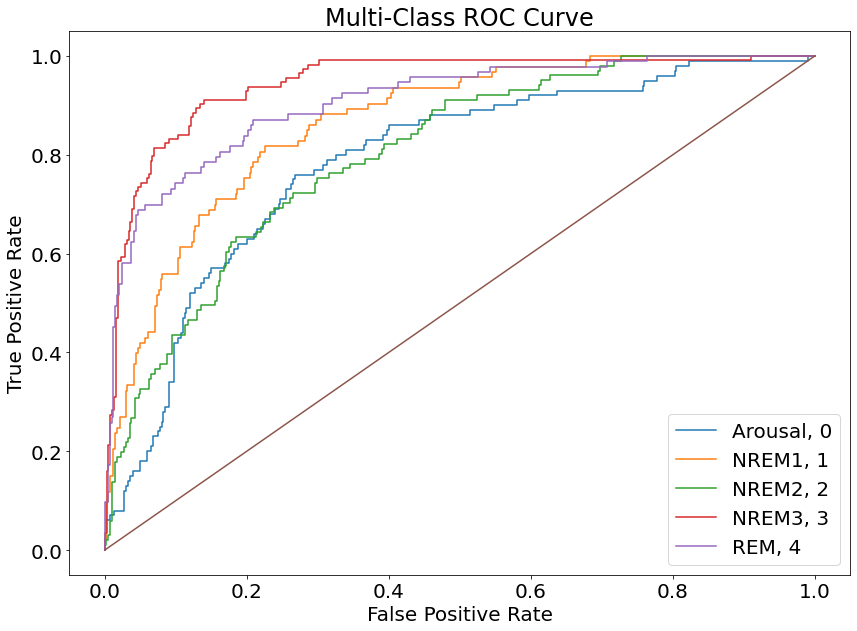

In [20]:
fpr = {}
tpr = {}
roc_auc = {}

""" Initalize key reference dictionaries """
sig_dict = {0:'O2-M1', 1:'E1-M2', 2:'Chin1-Chin2', 3:'ABD', 4:'CHEST', 5:'AIRFLOW', 6:'ECG'}
sig_type_dict = {0:'Time (s)', 1:'Frequency (Hz)'}
stage_dict = {0:'Arousal', 1:'NREM1', 2:'NREM2', 3:'NREM3', 4:'REM'}

plt.figure(figsize=(14,10))
for i in range(5):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_labels_one_hot.iloc[:, i], test_pred.iloc[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label = stage_dict[i] + ', ' + str(i))

plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()

fpr["micro"], tpr["micro"], _ = metrics.roc_curve(test_labels_one_hot.values.ravel(), test_pred.values.ravel())
roc_auc_agg = metrics.auc(fpr["micro"], tpr["micro"])

In [21]:
y_true = []
y_pred = []
for i in range(test_pred.shape[0]):
    if test_predict.iloc[i]==0: y_pred.append(1)
    else: y_pred.append(-1)
    if test_labels[i]==0: y_true.append(1)
    else: y_true.append(-1)
mcc = metrics.matthews_corrcoef(y_true, y_pred)

In [22]:
print(roc_auc_agg, mcc)

0.862758 0.36483468347234727
